In [1]:
from utils_project import * 

User detected: /Users/matty_gee
Initial n=576
Validation n=256
Combined n=832
Questionnaire items loaded


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Date collected

In [3]:
for s, sample in enumerate(samples[:2]):

    df = sample_dict[sample]['data']
    dates = df['date']
    dates = pd.to_datetime(dates, format='%Y-%m-%d')

    print(sample)
    start  = dates.min()
    end    = dates.max()
    length = end - start
    print(f'start: {start.date()}, end: {end.date()}, length: {length}')

    # count how many happened in half/length after start
    for i in range(2, 10)[::-1]:
        date  = start + length / i
        count = np.sum((dates >= start) & (dates <= date))
        print(f'completed 1/{i} way {date.date()} n={count}, {count / len(dates):.2%}')
    print('\n')

Initial
start: 2021-04-02, end: 2022-01-17, length: 290 days 00:00:00
completed 1/9 way 2021-05-04 n=480, 83.33%
completed 1/8 way 2021-05-08 n=487, 84.55%
completed 1/7 way 2021-05-13 n=494, 85.76%
completed 1/6 way 2021-05-20 n=502, 87.15%
completed 1/5 way 2021-05-30 n=510, 88.54%
completed 1/4 way 2021-06-13 n=517, 89.76%
completed 1/3 way 2021-07-07 n=528, 91.67%
completed 1/2 way 2021-08-25 n=544, 94.44%


Validation
start: 2022-02-08, end: 2022-02-12, length: 4 days 00:00:00
completed 1/9 way 2022-02-08 n=74, 28.91%
completed 1/8 way 2022-02-08 n=74, 28.91%
completed 1/7 way 2022-02-08 n=74, 28.91%
completed 1/6 way 2022-02-08 n=74, 28.91%
completed 1/5 way 2022-02-08 n=74, 28.91%
completed 1/4 way 2022-02-09 n=164, 64.06%
completed 1/3 way 2022-02-09 n=164, 64.06%
completed 1/2 way 2022-02-10 n=232, 90.62%




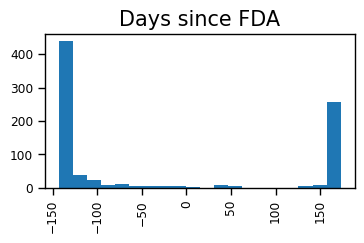

In [10]:
# get columns that have date in their name
date_data = data['date']
date_data = pd.to_datetime(date_data, format='%Y-%m-%d')

# get days since lockdown for date_data, put in data
data['days_since_lockdown']    = (date_data - pd.to_datetime('2020-03-15')).dt.days
data['days_since_vaccine_fda'] = (date_data - pd.to_datetime('2021-8-23')).dt.days

# plot date_data in histplot
plt.figure(figsize=(4,2))
plt.hist(data['days_since_vaccine_fda'], bins=20)
plt.xticks(rotation=90)
plt.title('Days since FDA')
plt.show()

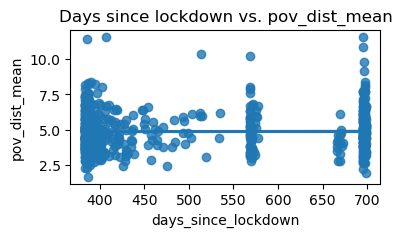

In [4]:
# regplot for date_since_lockdown and pov_dist_mean
plt.figure(figsize=(4,2))
sns.regplot(x='days_since_lockdown', y='pov_dist_mean', data=data)
plt.title('Days since lockdown vs. pov_dist_mean')
plt.show()


# Compare pre & post FDA approval for the vaccine

In [6]:
# which to test more
fa = 'quartimax_thresh25'
social_factor    = f'factor_social_{fa}'
mood_factor      = f'factor_mood_{fa}'
intrusive_factor = f'factor_intrusive_{fa}'
factor_labels = [social_factor, mood_factor, intrusive_factor]
factor_names  = ['Social Avoidance', 'Mood', 'Compulsion']
factor_dict   = dict(zip(factor_labels, factor_names))

In [8]:
data['after_vaccine_fda'] = (data['days_since_vaccine_fda'] > 0) * 1
print(f'N after vaccine = {np.sum(data["after_vaccine_fda"])}')

covid_vars = ['after_vaccine_fda']
beh_vars   = ['affil_mean_mean', 'power_mean_mean'] + list(factor_dict.keys())
ols_res    = []
for sample in ['Combined']:
    for cvd, beh in itertools.product(covid_vars, beh_vars):
        df     = flip_power(sample_dict[sample]['data'])
        ols_df = run_ols(cvd, beh, df)[0]
        ols_df.insert(0, 'sample', sample)
        ols_res.append(ols_df[ols_df['x'].isin([cvd])])
ols_df = pd.concat(ols_res).reset_index(drop=True)
ols_df['x'] = ols_df['x'].apply(lambda x: x.split('_')[0].capitalize())
print_df(ols_df)

N after vaccine = 288
|    | sample   | X                             | y                                   | x     |   dof |   adj_rsq |     bic |     aic |         beta |        se |     95%_lb |    95%_ub |         t |         p |   p_left |   p_right |
|---:|:---------|:------------------------------|:------------------------------------|:------|------:|----------:|--------:|--------:|-------------:|----------:|-----------:|----------:|----------:|----------:|---------:|----------:|
|  0 | Combined | Intercept + after_vaccine_fda | affil_mean_mean                     | After |   830 |    -0.001 |  -25.71 |  -35.16 | -0.000857843 | 0.0172438 | -0.0347044 | 0.0329887 | -0.049748 | 0.960335  | 0.480168 | 0.519832  |
|  1 | Combined | Intercept + after_vaccine_fda | power_mean_mean                     | After |   830 |     0     |  172.56 |  163.11 |  0.0214597   | 0.0194257 | -0.0166697 | 0.0595891 |  1.1047   | 0.269608  | 0.865196 | 0.134804  |
|  2 | Combined | Intercept + after_va

# Add in zipcode data
- actual virus: want case counts, deaths etc adjusted for population 
- political response: 

In [5]:
# get zip code data for 2020 from online
zip_info = pd.read_excel('../zip_codes.xlsx')
zip_info['zipcode'] = pd.to_numeric(zip_info['zipcode'], errors='coerce')
zip_info.head()

,state_fips,state,state_abbr,zipcode,county,city
0,1,Alabama,AL,35004.0,St. Clair,Acmar
1,1,Alabama,AL,35005.0,Jefferson,Adamsville
2,1,Alabama,AL,35006.0,Jefferson,Adger
3,1,Alabama,AL,35007.0,Shelby,Keystone
4,1,Alabama,AL,35010.0,Tallapoosa,New site


In [6]:
zip_col = 'demo_zip_code'

# force zip_col to be int
data[zip_col] = pd.to_numeric(data[zip_col], errors='coerce')
data[zip_col] = pd.to_numeric(data[zip_col], downcast='integer')
data = data[np.isfinite(data[zip_col])]

# count frequency for different numbers of digits in zip cols
print(data[zip_col].apply(lambda x: len(str(x))).value_counts())

# - mmm... why 7 for some? what should I do with the 3s?



5    502
7    317
4     35
6     20
3      4
8      1
Name: demo_zip_code, dtype: int64


In [7]:
# loop over each value in data[zip_col] and assign it to City, state by comparing it to zip_info['zipcode'], leave it as nan if no match
data['City']  = np.nan
data['State'] = np.nan
for i, row in data.iterrows():
    zip_val = row[zip_col]
    if np.isfinite(zip_val):

        # try to find a match in zip_info
        try:
            data.loc[i, 'City']  = zip_info.loc[zip_info['zipcode'] == zip_val, 'city'].values[0]
            data.loc[i, 'State'] = zip_info.loc[zip_info['zipcode'] == zip_val, 'state'].values[0]
        except:
            data.loc[i, 'City'] = np.nan
            data.loc[i, 'State'] = np.nan

# count frequency
print(data['State'].value_counts())


Texas             28
Florida           24
California        22
Michigan          15
Pennsylvania      15
Ohio              14
Illinois          13
New york          13
Virginia          12
Tennessee         10
Indiana           10
Missouri          10
North carolina     9
New jersey         9
Georgia            9
Kansas             6
Washington         6
Massachusetts      6
Louisiana          5
Arizona            4
Oklahoma           4
South carolina     3
Kentucky           3
Oregon             3
Arkansas           3
Alaska             3
Wisconsin          3
Connecticut        2
Iowa               2
Mississippi        2
Minnesota          2
Maryland           2
Nevada             2
Nebraska           1
Hawaii             1
Alabama            1
Vermont            1
Colorado           1
Utah               1
Delaware           1
North dakota       1
West virginia      1
Idaho              1
Name: State, dtype: int64


## Clean up & add some variables

Political party
- 1, Democrat
- 2, Republican
- 3, Independent (lean Democrat)
- 4, Independent (lean Republican)
- 5, Independent (no lean)


Education
- 1, 1-8 Less than high school
- 2, 9-11 Some high school
- 3, 12 High school degree
- 4, 13-15 Some college
- 5, 16 Bachelor's degree in college (4-year)
- 6, 17-25 Graduate School

In [8]:
# define the states in terms of whether it is a red or blue state in presidential elections
red_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Florida', 'Georgia', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 
'Montana', 'Nebraska', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'West Virginia', 'Wisconsin', 'Wyoming']
blue_states = ['California', 'Colorado', 'Connecticut', 'Delaware', 'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Vermont', 'Virginia', 'Washington']

# add a column to zip_data that is 1 if the state is red and 0 if it is blue
data['red_state'] = np.nan
for i, row in data.iterrows():
    state = row['State']
    if state in red_states:
        data.loc[i, 'red_state'] = 1
    elif state in blue_states:
        data.loc[i, 'red_state'] = 0

# count frequency
print(data['red_state'].value_counts())

1.0    144
0.0    104
Name: red_state, dtype: int64


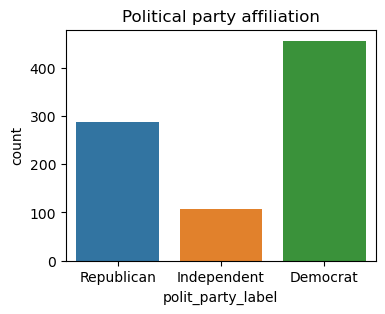

In [9]:
# - 1, Democrat
# - 2, Republican
# - 3, Independent (lean Democrat)
# - 4, Independent (lean Republican)
# - 5, Independent (no lean)

# add a column rescoring the political party
data['polit_party_label'] = np.nan
data['polit_party_rescored'] = np.nan
for i, row in data.iterrows():
    pol_party = row['demo_polit_party']
    if pol_party == 1 or pol_party == 3:
        data.loc[i, 'polit_party_rescored'] = 1
        data.loc[i, 'polit_party_label'] = 'Democrat'
    elif pol_party == 2 or pol_party == 4:
        data.loc[i, 'polit_party_rescored'] = 2
        data.loc[i, 'polit_party_label'] = 'Republican'
    elif pol_party == 5:
        data.loc[i, 'polit_party_rescored'] = 3
        data.loc[i, 'polit_party_label'] = 'Independent'

# plot the barplot for demo_polit_party_label with percent stat
plt.figure(figsize=(4,3))
sns.countplot(x='polit_party_label', data=data)
plt.title('Political party affiliation')
plt.show()



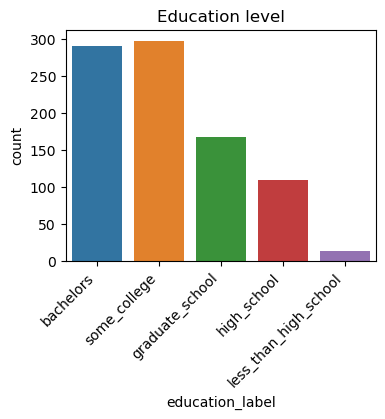

In [10]:
# - 1, 1-8 Less than high school
# - 2, 9-11 Some high school
# - 3, 12 High school degree
# - 4, 13-15 Some college
# - 5, 16 Bachelor's degree in college (4-year)
# - 6, 17-25 Graduate School

# add a column rescoring the education
data['education_label'] = np.nan
data['education_rescored'] = np.nan
for i, row in data.iterrows():
    education = row['demo_edu_level']

    if education == 1 or education == 2:
        data.loc[i, 'education_rescored'] = 1
        data.loc[i, 'education_label'] = 'less_than_high_school'
    elif education == 3:
        data.loc[i, 'education_rescored'] = 2
        data.loc[i, 'education_label'] = 'high_school'
    elif education == 4:
        data.loc[i, 'education_rescored'] = 3
        data.loc[i, 'education_label'] = 'some_college'
    elif education == 5:
        data.loc[i, 'education_rescored'] = 4
        data.loc[i, 'education_label'] = 'bachelors'
    elif education == 6:
        data.loc[i, 'education_rescored'] = 5
        data.loc[i, 'education_label'] = 'graduate_school'

# plot barplot 
plt.figure(figsize=(4,3))
sns.countplot(x='education_label', data=data)
plt.title('Education level')
# rotate xtick labels and shift right
plt.xticks(rotation=45, ha='right')
plt.show()



# Covid 19 vaccine

- 1 - Have you received? (1=yes, 2=no)
- 2 - Do you plan on getting? (1=yes, 2=no)


- 3 - if no, why? (select all that apply)
    - 1, had cov19 already
    - 2, dont trust vaccine
    - 3, dont think I need it
    - 4, prefer not to say

not at all -- somewhat -- a lot: 
- 4 - vaccines are generally safe: 
- 5 - vaccines are generally effective
- 6 - I am worried about politics interfering w/ cov19 vaccine 
- 7 - I am worried about racial justice w/ cov19 vaccine 
- 8 - I am worried about the pharma companies producing the cov19 vaccine

['cov19_vaccinated', 'cov19_willget', 'cov19_vaccine_no_reason___1', 'cov19_vaccine_no_reason___2', 'cov19_vaccine_no_reason___3', 'cov19_vaccine_no_reason___4', 'cov19_vaccines_safe', 'cov19_vaccines_effective', 'cov19_politics', 'cov19_experiment', 'cov19_race', 'cov19_pharma']


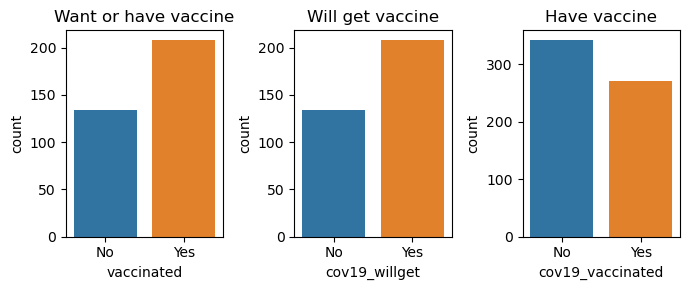

In [11]:
data['vaccinated'] = data['cov19_vaccinated'] + data['cov19_willget']

# find columns with covid in it
covid_cols = [col for col in data.columns if 'cov19' in col]
print(covid_cols)

# plot 3 subplots for vaccinated, will get vaccinated, and not vaccinated
fig, axs = plt.subplots(1, 3, figsize=(7,3))

sns.countplot(x='vaccinated', data=data, ax=axs[0])
axs[0].set_title('Want or have vaccine')
axs[0].set_xticklabels(['No', 'Yes'])

sns.countplot(x='cov19_willget', data=data, ax=axs[1])
axs[1].set_title('Will get vaccine')
axs[1].set_xticklabels(['No', 'Yes'])

sns.countplot(x='cov19_vaccinated', data=data, ax=axs[2])
axs[2].set_title('Have vaccine')
axs[2].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()


In [12]:
# find columns with demo in it
demo_cols = [col for col in data.columns if 'demo' in col]
print(demo_cols)

['demo_age', 'demo_sex_1F', 'demo_gender_1W', 'demo_race_amer_indian_or_alaska_native', 'demo_race_asian', 'demo_race_black/aa', 'demo_race_latino/hispanic', 'demo_race_multiracial', 'demo_race_nat_hawaiian_or_pac_isl', 'demo_race_white', 'demo_race_other', 'demo_race_other_text', 'demo_marriage', 'demo_handedness_1R', 'demo_edu_level', 'demo_occupation', 'demo_ladder_rate', 'demo_diag_6mo', 'demo_adjust', 'demo_adhd', 'demo_autism', 'demo_bipolar', 'demo_avpd', 'demo_bpd', 'demo_mdd', 'demo_ed', 'demo_gad', 'demo_ocd', 'demo_ld', 'demo_panic', 'demo_gambling', 'demo_ptsd', 'demo_scz', 'demo_spd', 'demo_sad', 'demo_tourettes', 'demo_sud', 'demo_other_disorder', 'demo_sud_specified', 'demo_psych_med_current', 'demo_psych_med_specified', 'demo_polit_party', 'demo_zip_code', 'demo_occupation_other', 'demo_social_media_1', 'demo_social_media_fb', 'demo_social_media_fb_freq', 'demo_social_media_fb_friends', 'demo_social_media_ig', 'demo_social_media_ig_freq', 'demo_social_media_ig_friends',

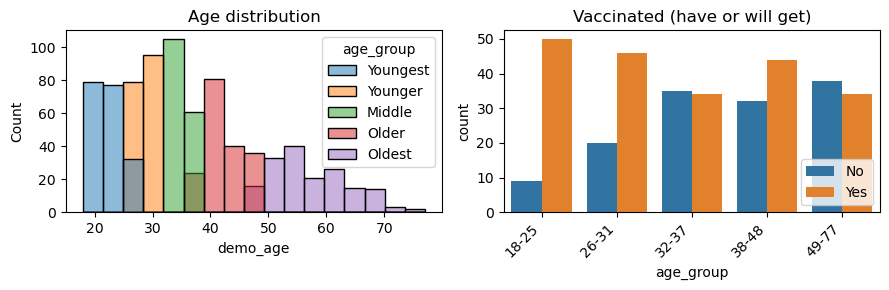

In [13]:
# use percentiles to split demo_age into 5 equally sized groups
data['age_group'] = pd.qcut(data['demo_age'], 5, labels=['Youngest', 'Younger', 'Middle', 'Older', 'Oldest'])
age_group_min = data.groupby('age_group')['demo_age'].min()
age_group_max = data.groupby('age_group')['demo_age'].max()
age_group_range = [f'{int(min_)}-{int(max_)}' for min_, max_ in zip(age_group_min, age_group_max)]


# plot subplots with 1 being age histplot for each age_group category and 2 being the count of vaccinated in each age_group
fig, axs = plt.subplots(1, 2, figsize=(9,3))

sns.histplot(x='demo_age', data=data, hue='age_group', ax=axs[0])
axs[0].set_title('Age distribution')

sns.countplot(x='age_group', data=data, hue='vaccinated', ax=axs[1])
axs[1].set_title('Vaccinated (have or will get)')
axs[1].set_xticklabels(age_group_range, rotation=45, ha='right')
axs[1].legend(['No', 'Yes'], loc='lower right')
plt.tight_layout()
plt.show()



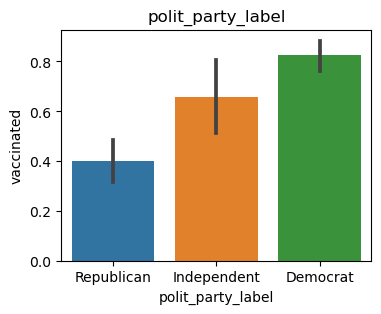

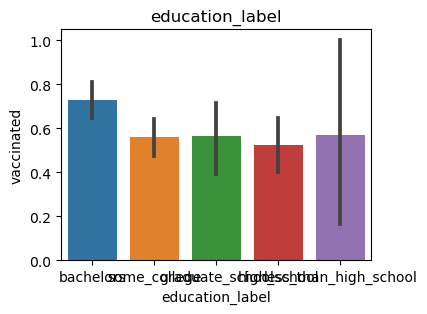

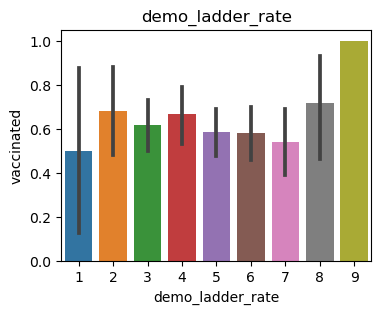

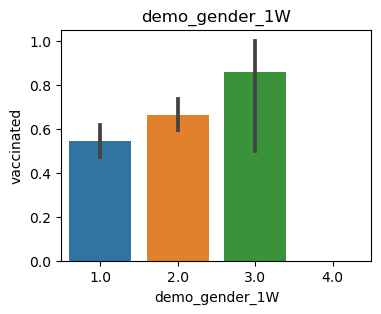

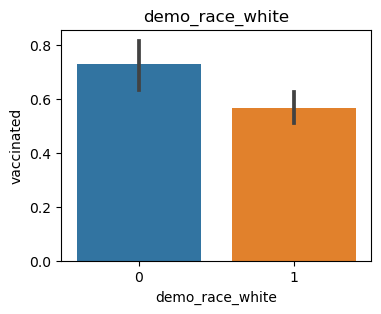

In [14]:
# create a new column of the sum the number of people who are vaccinated or will get vaccinated
demo_cols = ['polit_party_label', 'education_label', 'demo_ladder_rate', 'demo_gender_1W', 'demo_race_white']

# for each col in demo_cols, plot a barplot of vaccinated as a function of the col
# fig, ax = plt.subplots(2, 3, figsize=(12,6))
for col in demo_cols:
    plt.figure(figsize=(4,3))
    sns.barplot(x=col, y='vaccinated', data=data)
    plt.title(col)
    plt.show()

### Logistic regression to explain vaccination
POV distance is related: but maybe in other direction then I'd expect - more distance, less vaccine probability

(342, 3) (342,)
[[10 10]
 [ 8 41]]
0.7391304347826086
[0.5942029  0.73913043 0.64705882 0.60294118 0.63235294]


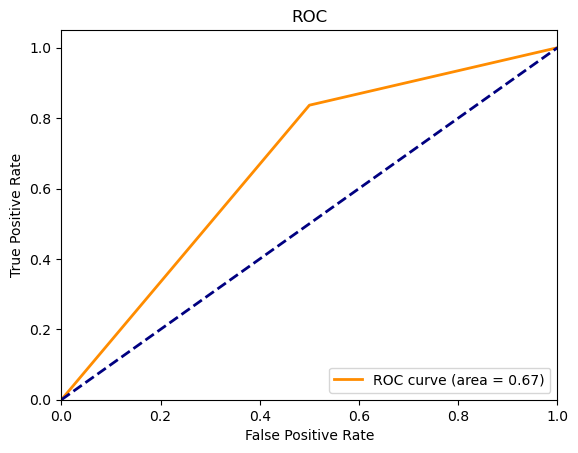

In [102]:
# build a model that predicts vaccination status based on demographic variables
# - use a logistic regression model
# - use cross validation to get a sense of how well the model generalizes
# - use a confusion matrix to get a sense of how well the model predicts

# import libraries used in this cell


#------------------------------------------------------------
# define the features and the target

demo_cols = ['demo_age', 'demo_polit_party', 'pov_dist_mean'] # , 'demo_ladder_rate'
X = zip_data[demo_cols]
y = zip_data['vaccinated']

# exclude rows with non-finite values in X or y
mask = (np.isfinite(y)) & (np.sum(np.isfinite(X), axis=1) == len(demo_cols))
X, y = X[mask], y[mask]
print(X.shape, y.shape)

#------------------------------------------------------------
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build the model
model = LogisticRegression()
model.fit(X_train, y_train)

# performance
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(np.sum(np.diag(cm)) / np.sum(cm))

# get the cross validation score
scores = cross_val_score(model, X, y, cv=5)
print(scores)

#------------------------------------------------------------
# plot ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [20]:
# subset zip_data to only democrat and republican
data_ = data[data['polit_party_label'].isin(['Democrat', 'Republican'])]

#------------------------------------------------------------
# build the model using statsmodels w/ whole dataset
# days_since_vaccine_fda + C(polit_party_label) + C(education_label) +
model = smf.logit('vaccinated ~  demo_age * pov_dist_mean + factor_social_min + factor_mood_min + factor_compulsive_min', data=data_)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.604936
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             vaccinated   No. Observations:                  286
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Dec 2022   Pseudo R-squ.:                 0.09207
Time:                        16:36:50   Log-Likelihood:                -173.01
converged:                       True   LL-Null:                       -190.56
Covariance Type:            nonrobust   LLR p-value:                 4.143e-06
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.1511      1.628      1.935      0.053      -0.041      

In [15]:
# build a regression with statsmodels with y as pov_dist_mean and X as vaccinated and social_factor_min
model = smf.ols(f'pov_dist_mean ~ C(vaccinated) + factor_social_min + factor_mood_min + factor_compulsive_min + {(" + ").join(demo_controls)}', data=data_)
result = model.fit()
print(result.summary())


NameError: name 'data_' is not defined

### Other variables associated with Covid vaccine

In [182]:
# get other variables with cov19 in name
cov19_cols = [col for col in data.columns if 'cov19' in col]
print(cov19_cols)

['cov19_vaccinated', 'cov19_willget', 'cov19_vaccine_no_reason___1', 'cov19_vaccine_no_reason___2', 'cov19_vaccine_no_reason___3', 'cov19_vaccine_no_reason___4', 'cov19_vaccines_safe', 'cov19_vaccines_effective', 'cov19_politics', 'cov19_experiment', 'cov19_race', 'cov19_pharma']


In [31]:
# # # plot regplot for pov_dist_mean and cov19_vaccines_safe
# sns.regplot(x='pov_dist_mean', y='cov19_experiment', data=data_)
# plt.show()

# Lockdown policies

In [ ]:

# # get covid data from online
# covid_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
# covid_data = covid_data[covid_data['county'] == 'Los Angeles']
# covid_data = covid_data[covid_data['date'] == '2020-05-01']
# covid_data = covid_data[['fips', 'cases', 'deaths']]
# covid_data = covid_data.rename(columns={'fips': 'zip'})
# covid_data.reset_index(drop=True, inplace=True)

In [ ]:
# # get covid lockdown data from online
# lockdown_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
# lockdown_data = lockdown_data[lockdown_data['state'] == 'California']